<a href="https://colab.research.google.com/github/jpcompartir/dl_notebooks/blob/main/keras_imdb_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


We'll be classifying the IMDB dataset (dejavu)according to whether the sentiment of each review is positive or negative - hence binary classification!

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000) #Keeping the top 10k most frequent words of the dataset's vocab. As opposed to the ~88.5k unique words in total (keeping the size of our data down)

Looking at the data we can see that each post is a series of integers - the text has come ready tokenised.

In [3]:
train_data[0], train_labels[0]

([1,
  14,
  22,
  16,
  43,
  530,
  973,
  1622,
  1385,
  65,
  458,
  4468,
  66,
  3941,
  4,
  173,
  36,
  256,
  5,
  25,
  100,
  43,
  838,
  112,
  50,
  670,
  2,
  9,
  35,
  480,
  284,
  5,
  150,
  4,
  172,
  112,
  167,
  2,
  336,
  385,
  39,
  4,
  172,
  4536,
  1111,
  17,
  546,
  38,
  13,
  447,
  4,
  192,
  50,
  16,
  6,
  147,
  2025,
  19,
  14,
  22,
  4,
  1920,
  4613,
  469,
  4,
  22,
  71,
  87,
  12,
  16,
  43,
  530,
  38,
  76,
  15,
  13,
  1247,
  4,
  22,
  17,
  515,
  17,
  12,
  16,
  626,
  18,
  2,
  5,
  62,
  386,
  12,
  8,
  316,
  8,
  106,
  5,
  4,
  2223,
  5244,
  16,
  480,
  66,
  3785,
  33,
  4,
  130,
  12,
  16,
  38,
  619,
  5,
  25,
  124,
  51,
  36,
  135,
  48,
  25,
  1415,
  33,
  6,
  22,
  12,
  215,
  28,
  77,
  52,
  5,
  14,
  407,
  16,
  82,
  2,
  8,
  4,
  107,
  117,
  5952,
  15,
  256,
  4,
  2,
  7,
  3766,
  5,
  723,
  36,
  71,
  43,
  530,
  476,
  26,
  400,
  317,
  46,
  7,
  4,
  2,
  1029,
  

We can go from integers back to original tokens and original text(minus the lower frequency words which have been clipped from the dataset via the num_words = 10000 argument). Indices are off by 3 (i - 3) because tokens 0,1, and 2 are reserved indices for padding, start of sequence & unknown respectively.

In [4]:
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join([reverse_word_index.get(i - 3, "?") for i in train_data[0]])

Define a quick function to do this for any review within the data, setting train_data as the default arg for data in case wanting to call the function many times etc.

In [5]:
def decode_review(index, data = train_data):
  word_index = imdb.get_word_index()
  reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
  
  return " ".join([reverse_word_index.get(i - 3, "?") for i in data[index]])


In [6]:
decode_review(2)

"? this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had ? working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how ? this is to watch save yourself an hour a bit of your life"

In [7]:
len(train_data[0]), len(train_data[1])

(218, 189)

We notice that the length of each list (each document is now a list of integers) differs, and we recall that neural networks (and more generally matrix multiplication) require inputs to be of a certain shape - in the case of neural networks we need tensors of precisely the same shape, so we need to either pad, or truncate our sequences so that they are of the same length. 

---
We could either condense our lists (or vectors) into dense word embeddings, or sparsely encode with one-hot vectors i.e. if our document contains one word, which is tokenised to the integer 5, put a one in the 5th index position and put a 0 in the other 9999 index positions. For now we will one-hot encode each document by defining a vectorise_sequence function, which instatiates a tensor of the appropriate shape, then enumerates each list (gives each element an index position), maps over each index, and sequence in the enumerated list, then maps over each integer (j) in each sequence, and sets the ith jth index of the tensor as 1.


In [8]:
def vectorise_sequences(sequences, dimension = 10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    for j in sequence:
      results[i, j] = 1
  return results

In [9]:
x_train = vectorise_sequences(train_data)
x_test = vectorise_sequences(test_data)

In [10]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

 Now we have input data in the form of tensors, and input labels as scalars (1, 0) for the binary classification. We instantiate a model with two intermediate layers with 16 units and a relu activation function, followed by a classification head with a sigmoid (logisitic) activation function.

In [11]:
model = keras.Sequential([
                          layers.Dense(16, activation = "relu"),
                          layers.Dense(16, activation = "relu"),
                          layers.Dense(1, activation = "sigmoid")
])

Then compile the model with a loss function, an optimiser and some metrics. As we are attempting binary classification, we'll use an rmsprop optimiser, binary cross entropy loss function & accuracy as a metric (the labels are balances so accuracy is fine.



In [12]:
model.compile(optimizer = "rmsprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [13]:
(np.count_nonzero(train_labels == 0), np.count_nonzero(train_labels == 1)), (np.count_nonzero(test_labels == 0), np.count_nonzero(test_labels ==1))

((12500, 12500), (12500, 12500))

We have the test & training sets, but we also need a validation set that we validate the final model on.

In [14]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [15]:
history = model.fit(partial_x_train, partial_y_train,
                    epochs = 20, batch_size = 512,
                    validation_data = (x_val, y_val))

Epoch 1/20
30/30 [==============================] - 3s 41ms/step - loss: 0.5256 - accuracy: 0.7849 - val_loss: 0.4015 - val_accuracy: 0.8719
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3239 - accuracy: 0.9004 - val_loss: 0.3187 - val_accuracy: 0.8823
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2303 - accuracy: 0.9271 - val_loss: 0.2852 - val_accuracy: 0.8893
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1845 - accuracy: 0.9408 - val_loss: 0.2754 - val_accuracy: 0.8887
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1507 - accuracy: 0.9519 - val_loss: 0.2795 - val_accuracy: 0.8873
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1256 - accuracy: 0.9627 - val_loss: 0.3189 - val_accuracy: 0.8774
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1039 - accuracy: 0.9707 - val_loss: 0.3308 - val_accuracy: 0.8765
Epoch 8/20
30

Validation accuracy @ 88.7% in best model version. Can see the overtraining effect as the val_loss keeps increasing after about epoch ~ 10. But let's plot the outcome. We saved our results as history.

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

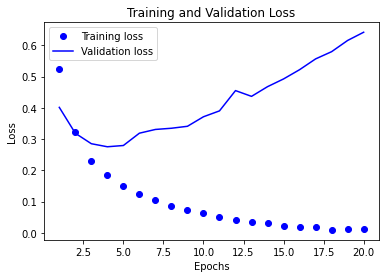

In [17]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label = "Training loss")
plt.plot(epochs, val_loss_values, "b", label = "Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Looking at the loss plot, we can track the epoch at which overitting becomes a big problem.

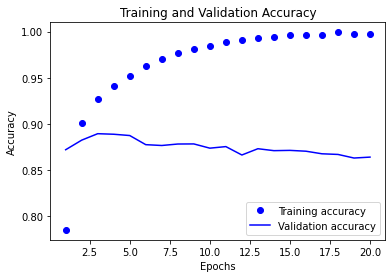

In [18]:
plt.clf() 
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

plt.plot(epochs, acc, "bo", label = "Training accuracy")
plt.plot(epochs, val_acc, "b", label = "Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()


In [19]:
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

It looks like ~4 is the appropriate value for epochs

In [20]:
model = keras.Sequential([
    layers.Dense(16, "relu"),
    layers.Dense(16, "relu"),
    layers.Dense(1, "sigmoid")
])



In [21]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = "rmsprop",
    metrics = ["accuracy"])

In [22]:
model.fit(x_train,y_train, epochs = 4, batch_size = 512)

results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 12ms/step - loss: 0.4630 - accuracy: 0.8176
Epoch 2/4
49/49 [==============================] - 1s 12ms/step - loss: 0.2691 - accuracy: 0.9053
Epoch 3/4
49/49 [==============================] - 1s 12ms/step - loss: 0.2068 - accuracy: 0.9268
Epoch 4/4
782/782 [==============================] - 2s 3ms/step - loss: 0.2868 - accuracy: 0.8861


In [23]:
results

[0.2868165373802185, 0.8861200213432312]

Model is now trained, can use the predict method to predict the labels for reviews now:

In [24]:
model.predict(x_test[0:5])

array([[0.21526581],
       [0.9995272 ],
       [0.9113534 ],
       [0.8519663 ],
       [0.9552912 ]], dtype=float32)

array([0., 1., 1., ..., 0., 0., 0.])